In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from biodatatools.utils.common import json_load
import subprocess
import glob
from os.path import exists
import os
from pathlib import Path
import sys
import numpy as np
from scipy.stats import pearsonr
import re

In [3]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [4]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

In [5]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from data_loading import extract_observed_profiles
from performance_metrics import profile_jsd

# Overall performance

In [6]:
# The models were trained using default parameters except with “in_window” set to 1,000 and “out_window” set to 500

labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")
groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")
folders = glob.glob(f"{PROJECT_DIR_o}procapnet/deepshap_out/*")
models = [folder.split("/")[-1] for folder in folders if folder.split("/")[-1] in groups["normal_tissues"]]

In [7]:
bws = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_bws.json")

In [8]:
model_type = "strand_merged_umap"

In [9]:
timestamps = {}
for s in models:
	files = glob.glob(f"{PROJECT_DIR_o}procapnet/models/{s}/{model_type}/*.model")
	timestamps[s] = sorted([f.split("/")[-1].split(".model")[0] for f in files])

In [10]:
results = []
for s in models:
	for timestamp in timestamps[s]:
		logfile = f"{PROJECT_DIR_o}procapnet/model_out/{s}/{model_type}/{timestamp}/test_run_log.txt"
		with open(logfile, "r") as f:
		    text = f.read()
		count_corr_match = re.search(r"Mean count_pearson:\s*([0-9.]+)", text)
		mean_count_pearson = float(count_corr_match.group(1))
		jsd_match = re.search(r"Mean jsd:\s*([0-9.]+)", text)
		mean_jsd = float(jsd_match.group(1))
		results.append([f"{labels[s][1]} ({s})", timestamp, mean_count_pearson, mean_jsd])
df_metrics = pd.DataFrame(results, columns=["model", "fold", "corr", "jsd"])
df_metrics.head(2)

,model,fold,corr,jsd
0,Large intestine (EN5),2024-07-05_02-50-08,0.720280,0.347723
1,Large intestine (EN5),2024-07-21_02-10-29,0.731445,0.357402


In [11]:
tasks = ["count", "profile"]

In [25]:
def plot_metrics(df, metric, title, ylabel, outputfile):
	order = sorted(list(set(df_metrics["model"])))
	
	fig, ax = plt.subplots(figsize=(6.9,2.5))
	g = sns.stripplot(df, x="model", y=metric, order=order,
					  c="#000000", size=3, ax=ax)
	sns.barplot(df, x="model", y=metric, order=order, edgecolor="#80b1d3",
					fill=False, errorbar=None, width=0.6, linewidth=lw, ax=ax)
	g.spines[["top","right"]].set_visible(False)
	g.set_title(title, fontsize=bfontsize)
	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize, rotation=30)
	for label in ax.get_xticklabels():
		label.set_horizontalalignment('right')
	
	g.set_ylabel(ylabel, fontsize=bfontsize)
	g.tick_params(axis="y", labelsize=sfontsize)

	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

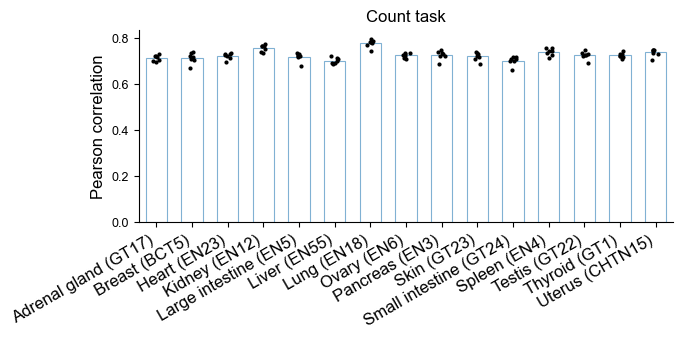

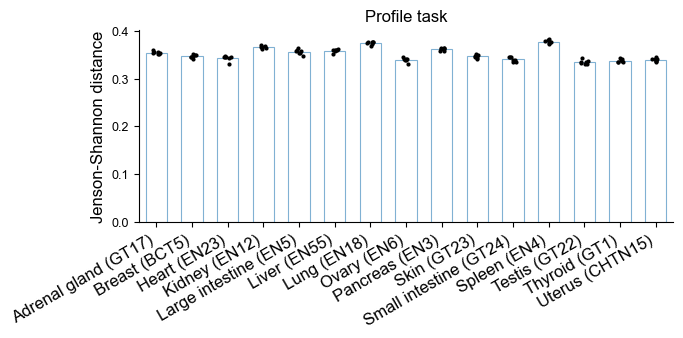

In [27]:
for task in tasks:
	metric = "corr" if task == "count" else "jsd"
	title = f"{task.capitalize()} task"
	ylabel = "Pearson correlation" if task == "count" else "Jenson-Shannon distance"
	figN = "a" if task == "count" else "c"
	outputfile = f"{PROJECT_DIR_o}figures/SuppFig4{figN}.pdf"
	plot_metrics(df_metrics, metric, title, ylabel, outputfile)

# EN55

## Count task

In [22]:
s = "EN55"

In [15]:
# Get observed profiles

obs_profs = {}
for fold in range(1,8):
	obs_profs[fold] = extract_observed_profiles(bws[s][0],
												bws[s][1],
												f"{PROJECT_DIR_o}procapnet/processed/{s}/peaks_fold{fold}_test.bed.gz",
												out_window=500)

== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks_fold1_test.bed.gz
Profile length: 500
Num. Examples: 8846
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks_fold2_test.bed.gz
Profile length: 500
Num. Examples: 8563
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks_fold3_test.bed.gz
Profile length: 500
Num. Examples: 8873
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks_fold4_test.bed.gz
Profile length: 500
Num. Examples: 8196
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks_fold5_test.bed.gz
Profile length: 500
Num. Examples: 9542
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks_fold6_test.bed.gz
Profile length: 500
Num. Examples: 11227
== In Extract Profile

In [16]:
# Get observed counts

obs_logcounts = {}
for fold in obs_profs:
	obs_logcounts[fold] = np.log(obs_profs[fold].sum(axis=(1, 2))).tolist()

In [23]:
# Get predicted counts

pred_logcounts = {}
for k in timestamps[s]:
	fold, timestamp = k.split(".")
	pred_logcounts[int(fold)] = np.load(f"{PROJECT_DIR_o}procapnet/model_out/{s}/{model_type}/{k}/test_pred_logcounts.npy").squeeze().tolist()

In [24]:
xs = [v for fold in range(1,8) for v in obs_logcounts[fold]]
ys = [v for fold in range(1,8) for v in pred_logcounts[fold]]
corr = pearsonr(xs, ys)[0]

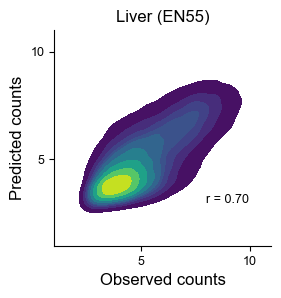

In [25]:
fig, ax = plt.subplots(figsize=(2.8,2.8))
g = sns.kdeplot(x=xs, y=ys, cmap="viridis", fill=True, ax=ax)
g.spines[["top", "right"]].set_visible(False)
g.text(x=8, y=3, s=f"r = {corr:.2f}", fontsize=sfontsize)
g.set_title(f"{labels[s][1]} ({s})", fontsize=bfontsize)
g.set_xlabel("Observed counts", fontsize=bfontsize)
g.set_ylabel("Predicted counts", fontsize=bfontsize)
g.set_xlim([1,11])
g.set_ylim([1,11])
g.set_xticks([5,10])
g.set_yticks([5,10])
g.tick_params(labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig4b.pdf", bbox_inches="tight", transparent=True)

## Profile task

In [26]:
# Get observed profiles for biological replicates

obs_profs2 = {}
for rep in [f"{s}a", f"{s}b"]:
	obs_profs2[rep] = extract_observed_profiles(f"/home/kl945/EnhancerAtlas/PROcap/Alignments/{rep}_5pl.bw",
											f"/home/kl945/EnhancerAtlas/PROcap/Alignments/{rep}_5mn.bw",
											f"{PROJECT_DIR_o}procapnet/processed/{s}/peaks.bed.gz",
											out_window=1000)

== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks.bed.gz
Profile length: 1000
Num. Examples: 63427
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/EN55/peaks.bed.gz
Profile length: 1000
Num. Examples: 63427


In [27]:
# Get predicted profiles

pred_profs = {}
for k in timestamps[s]:
	fold, timestamp = k.split(".")
	pred_profs[int(fold)] = np.load(f"{PROJECT_DIR_o}procapnet/model_out/{s}/{model_type}/{k}/test_pred_profiles.npy")

In [28]:
# Concatenate across folds

obs_profs_all = np.concatenate([obs_profs[fold] for fold in range(1,8)], axis=0)
pred_profs_all = np.concatenate([pred_profs[fold] for fold in range(1,8)], axis=0)

In [29]:
# Get averaged observed profiles

avg_obs_profs = np.tile(obs_profs_all.mean(axis=0, keepdims=True), (len(obs_profs_all),1,1))

In [30]:
def reshape(arr):
	arr = arr.reshape(arr.shape[0], -1)
	arr = np.expand_dims(arr, (1, 3))
	return arr

In [31]:
def get_jsd(arr1, arr2):
	arr1, arr2 = [reshape(arr) for arr in [arr1, arr2]]
	sum1, sum2 = [np.sum(arr, axis=(1,2,3)) for arr in [arr1, arr2]]
	mask = (sum1 != 0) & (sum2 != 0)
	arr1_filtered, arr2_filtered = [arr[mask] for arr in [arr1, arr2]]

	jsd = profile_jsd(arr1_filtered, arr2_filtered, 
						prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81,
						smooth_true_profs=False).flatten().tolist()
	return jsd

In [33]:
jsd = {"Technical replicates": get_jsd(obs_profs2[f"{s}a"], obs_profs2[f"{s}b"]),
	   "Predicted vs. Observed": get_jsd(pred_profs_all, obs_profs_all),
	   "Average observed\nvs. Observed": get_jsd(avg_obs_profs, obs_profs_all)
	  }

In [34]:
df_jsd = pd.DataFrame([{"group": k, "jsd": v}
				    for k, values in jsd.items()
				    for v in values
				])
df_jsd.head(2)

,group,jsd
0,Technical replicates,0.06369
1,Technical replicates,0.06369


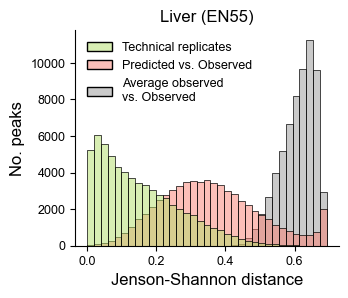

In [35]:
fig, ax = plt.subplots(figsize=(3.4, 2.8))
g = sns.histplot(data=df_jsd, x="jsd", hue="group", bins=35, alpha=0.5,
			palette=["#b3de69", "#fb8072", "#969696"], ax=ax
			)
g.spines[["top", "right"]].set_visible(False)
sns.move_legend(ax, loc="upper left", fontsize=sfontsize, frameon=False, title="")
g.set_title(f"{labels[s][1]} ({s})", fontsize=bfontsize)
g.set_xlabel("Jenson-Shannon distance", fontsize=bfontsize)
g.set_ylabel("No. peaks", fontsize=bfontsize)
g.tick_params(labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig4d.pdf", bbox_inches="tight", transparent=True)